In [40]:
import sys

sys.path.append("../../")

In [41]:
import gymnasium as gym
from vectorhash import build_vectorhash_architecture
from shifts import RatShift
from smoothing import RatSLAMSmoothing
from miniworld.params import DEFAULT_PARAMS
from miniworld_agent import MiniworldVectorhashAgent
import math
import torch
from preprocessing_cnn import GrayscaleAndFlattenPreprocessing, PreprocessingCNN
import matplotlib.pyplot as plt
from matplotlib import axes
from graph_utils import plot_probability_distribution_on_ax


### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

shapes = [(5, 5, 5), (8, 8, 8)]
N = 10


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    env = gym.make(
        "MiniWorld-CollectHealth-v0",
        max_episode_steps=-1,
        params=params,
        domain_rand=False,
    )
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env_cnn, limits = make_env()
env_no_cnn, limits = make_env()
model_cnn = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=128,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)
model_no_cnn = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=60 * 80,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)

#### preprocessor
cnn_preproc = PreprocessingCNN(
    device=device,
    latent_dim=128,
    input_channels=3,
    target_size=(224, 224),
    model_path="resnet18_adapter.pth",
)

grayscale_flatten_preproc = GrayscaleAndFlattenPreprocessing(device=device)

#### agents
agent_cnn = MiniworldVectorhashAgent(model_cnn, env_cnn, preprocessor=cnn_preproc)

agent_no_cnn = MiniworldVectorhashAgent(
    model_no_cnn, env_no_cnn, preprocessor=grayscale_flatten_preproc
)

by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


info for each h directly after learning it
h max, min, mean tensor(6.6774, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8386, device='cuda:0')
h_from_s max, min, mean tensor(6.6758, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8382, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0189, device='cuda:0') tensor(1.4875, device='cuda:0') tensor(1.7228, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(541, device='cuda:0') tensor(541, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(541, device='cuda:0') tensor(541, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(2.8286e-07, device='cuda:0') tensor([1.0000], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.6214, device='cuda:0') tensor([0.8233], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(3.2602e-10, device='cuda:0')

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.S

info for each h directly after learning it
h max, min, mean tensor(6.9764, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7797, device='cuda:0')
h_from_s max, min, mean tensor(6.9764, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7797, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0353, device='cuda:0') tensor(1.3951, device='cuda:0') tensor(1.7231, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(545, device='cuda:0') tensor(545, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(545, device='cuda:0') tensor(545, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(1.1338e-10, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.6849, device='cuda:0') tensor([0.8083], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(3.0179e-10, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 4800])) that is different to the input size (torch.Size([4800])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:132: UserWarning: Using a target size (torch.Size([1, 4800])) that is different to the input size (torch.Size([4800])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:139: UserWarning: Using a target size (torch.Size([1, 4800])) that is different to the 

In [42]:
start_state = agent_no_cnn.vectorhash.scaffold.g
print("start state:", start_state)
print("grid limits:", agent_no_cnn.vectorhash.scaffold.grid_limits)
print("world limits:", limits)
print("scale factor:", agent_no_cnn.vectorhash.scaffold.scale_factor)

start state: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [43]:
begin = agent_no_cnn.get_true_pos(env_no_cnn)
end = begin + 1 / agent_no_cnn.vectorhash.scaffold.scale_factor
dist = torch.distributions.uniform.Uniform(low=begin, high=end)
samples = dist.sample((N,))
grid_states = agent_no_cnn.vectorhash.scaffold.scale_factor * (samples - begin)

In [44]:
print("samples:", samples)
print("grid states:", grid_states)

samples: tensor([[7.0882, 6.5456, 1.1149],
        [6.7706, 6.5670, 1.0551],
        [6.8176, 6.7579, 0.9741],
        [6.9150, 6.7064, 1.0966],
        [6.8404, 6.4932, 1.0349],
        [6.8875, 6.7299, 1.0148],
        [7.0177, 6.4484, 1.0553],
        [7.0009, 6.6700, 0.9672],
        [7.0559, 6.4481, 1.0358],
        [6.9754, 6.7549, 1.0747]], device='cuda:0')
grid states: tensor([[0.9909, 0.3727, 0.9549],
        [0.1971, 0.4260, 0.5738],
        [0.3145, 0.9034, 0.0586],
        [0.5581, 0.7746, 0.8380],
        [0.3714, 0.2416, 0.4452],
        [0.4891, 0.8333, 0.3174],
        [0.8147, 0.1297, 0.5755],
        [0.7727, 0.6836, 0.0148],
        [0.9104, 0.1290, 0.4512],
        [0.7089, 0.8959, 0.6987]], device='cuda:0')


info for each h directly after learning it
h max, min, mean tensor(6.9764, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7797, device='cuda:0')
h_from_s max, min, mean tensor(6.9764, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7797, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0353, device='cuda:0') tensor(1.3951, device='cuda:0') tensor(1.7231, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(545, device='cuda:0') tensor(545, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(545, device='cuda:0') tensor(545, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(2.7480e-11, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.6849, device='cuda:0') tensor([0.8083], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(7.5497e-11, device='cuda:0') ten

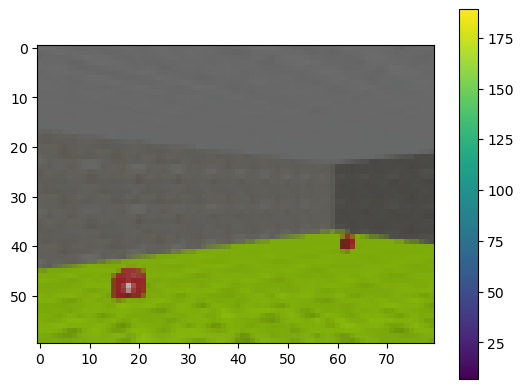

In [45]:
first_img, first_pos = agent_no_cnn._env_reset(env_cnn)
first_img, first_pos = agent_no_cnn._obs_postpreprocess(agent_no_cnn.env.step(4), 4)
m = plt.imshow(first_img)
plt.colorbar(m)
agent_no_cnn.vectorhash.store_memory(s=agent_no_cnn.preprocessor.encode(first_img))
agent_cnn.vectorhash.store_memory(s=agent_cnn.preprocessor.encode(first_img))

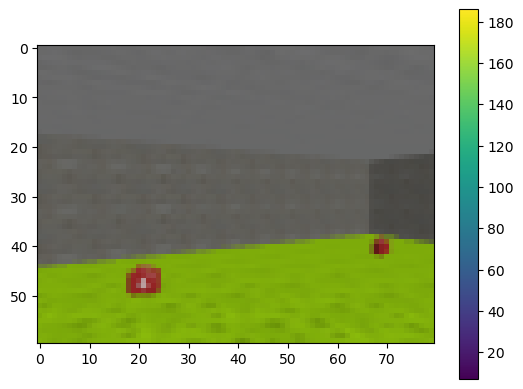

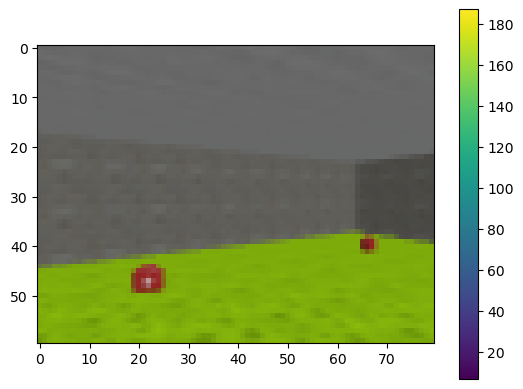

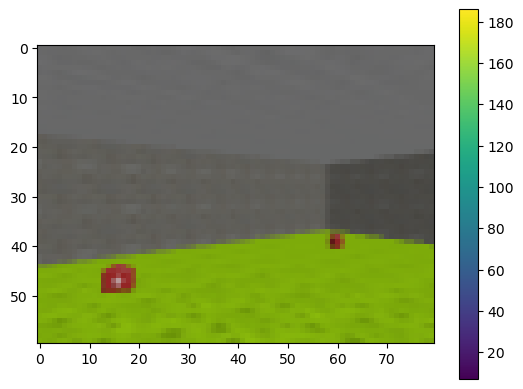

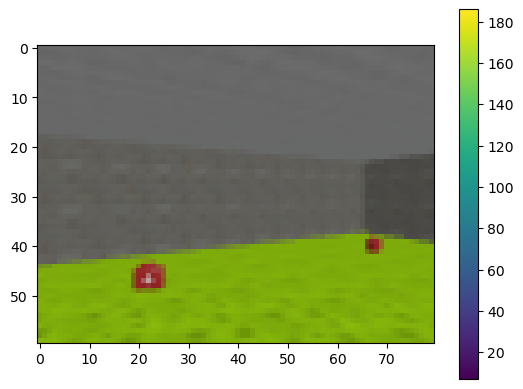

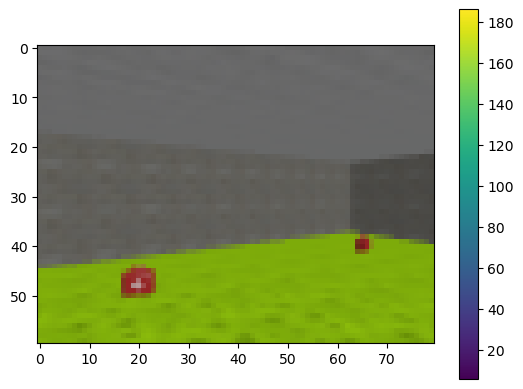

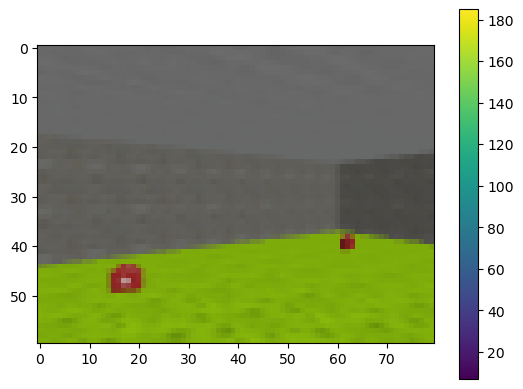

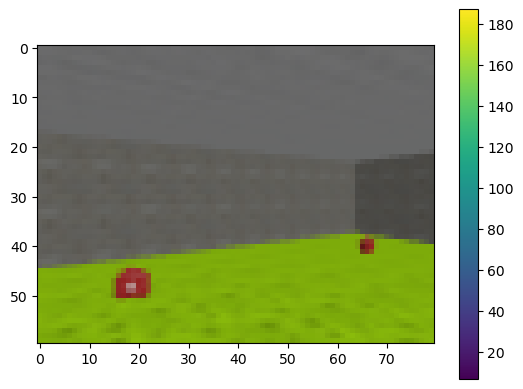

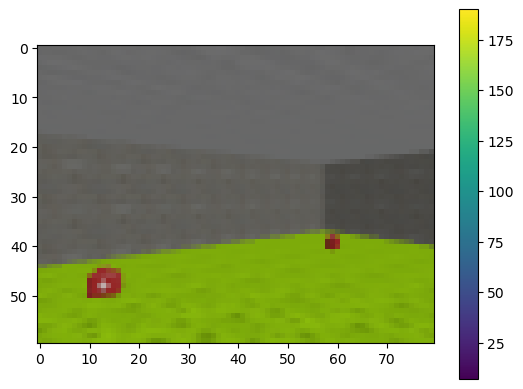

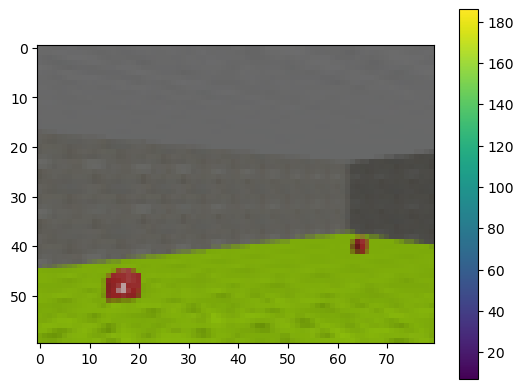

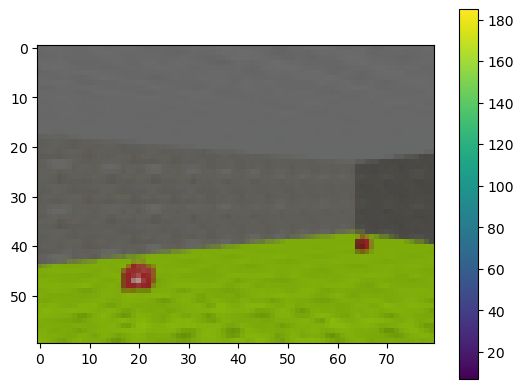

In [46]:
imgs = []
states_cnn = []
states_no_cnn = []
for sample in samples:
    pos = sample.cpu().numpy()
    agent_no_cnn.set_agent_pos(pos)
    agent_cnn.set_agent_pos(pos)
    img, _ = agent_no_cnn._obs_postpreprocess(agent_no_cnn.env.step(4), 4)
    obs_cnn = agent_cnn.preprocessor.encode(img)
    obs_no_cnn = agent_no_cnn.preprocessor.encode(img)
    g_cnn = agent_cnn.vectorhash.scaffold.denoise(
        agent_cnn.vectorhash.scaffold.grid_from_hippocampal(
            agent_cnn.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(
                obs_cnn
            )
        )
    )
    g_no_cnn = agent_no_cnn.vectorhash.scaffold.denoise(
        agent_no_cnn.vectorhash.scaffold.grid_from_hippocampal(
            agent_no_cnn.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(
                obs_no_cnn
            )
        )
    )
    m = plt.imshow(img)
    plt.colorbar(m)
    plt.show()
    imgs.append(img)
    states_cnn.append(g_cnn)
    states_no_cnn.append(g_no_cnn)

Text(0.5, 0.98, 'probability mass across g (cnn)')

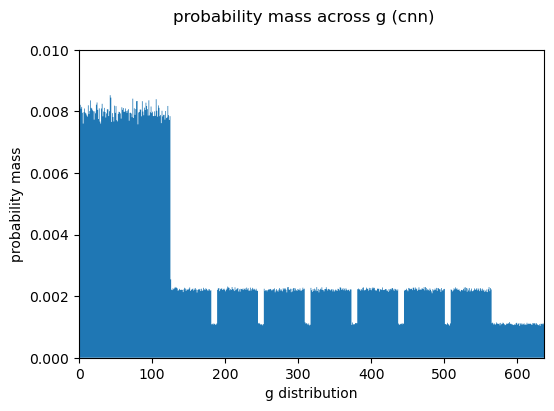

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_probability_distribution_on_ax(states_cnn[0][0].cpu(), ax)

ax.set_ylim(0, 0.01)
ax.set_xlim(0, len(states_cnn[0][0]))
ax.set_ylabel("probability mass")

ax.set_xlabel("g distribution")

fig.suptitle("probability mass across g (cnn)")

In [ ]:
fig.savefig('results_across_g_cnn.png')

Text(0.5, 0.98, 'probability mass across g (no_cnn)')

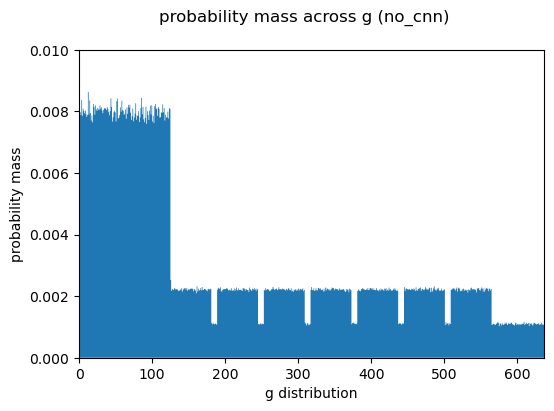

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_probability_distribution_on_ax(states_no_cnn[0][0].cpu(), ax)

ax.set_ylim(0, 0.01)
ax.set_xlim(0, len(states_cnn[0][0]))
ax.set_ylabel("probability mass")

ax.set_xlabel("g distribution")

fig.suptitle("probability mass across g (no_cnn)")

In [50]:
fig.savefig('results_across_g_no_cnn.png')

In [51]:
cnn_x_dists = []
cnn_y_dists = []
cnn_theta_dists = []
no_cnn_x_dists = []
no_cnn_y_dists = []
no_cnn_theta_dists = []

for i in range(N):
    agent_cnn.vectorhash.scaffold.modules = (
        agent_cnn.vectorhash.scaffold.modules_from_g(states_cnn[i][0])
    )
    agent_no_cnn.vectorhash.scaffold.modules = (
        agent_no_cnn.vectorhash.scaffold.modules_from_g(states_no_cnn[i][0])
    )

    cnn_x_dists.append(agent_cnn.vectorhash.scaffold.expand_distribution(0).cpu())
    cnn_y_dists.append(agent_cnn.vectorhash.scaffold.expand_distribution(1).cpu())
    cnn_theta_dists.append(agent_cnn.vectorhash.scaffold.expand_distribution(2).cpu())
    no_cnn_x_dists.append(agent_no_cnn.vectorhash.scaffold.expand_distribution(0).cpu())
    no_cnn_y_dists.append(agent_no_cnn.vectorhash.scaffold.expand_distribution(1).cpu())
    no_cnn_theta_dists.append(agent_no_cnn.vectorhash.scaffold.expand_distribution(2).cpu())

Text(0.5, 0.98, 'probability mass across dimension distributions (cnn)')

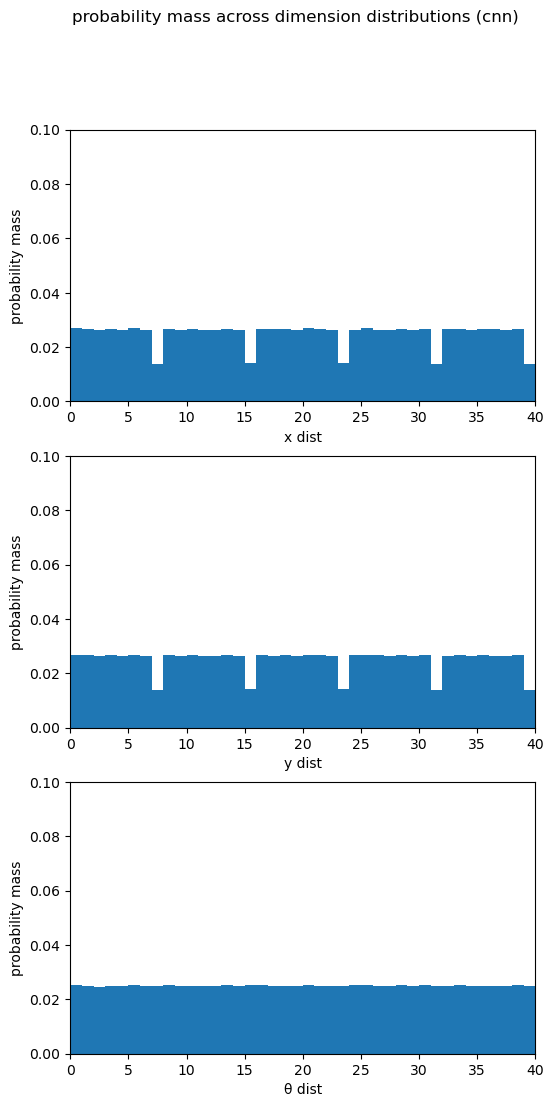

In [52]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

plot_probability_distribution_on_ax(cnn_x_dists[0], axs[0])
axs[0].set_xlabel('x dist')
axs[0].set_xlim(0, len(cnn_x_dists[0]))

plot_probability_distribution_on_ax(cnn_y_dists[0], axs[1])
axs[1].set_xlabel('y dist')
axs[1].set_xlim(0, len(cnn_y_dists[0]))

plot_probability_distribution_on_ax(cnn_theta_dists[0], axs[2])
axs[2].set_xlabel('θ dist')
axs[2].set_xlim(0, len(cnn_theta_dists[0]))

for i in range(3):
  axs[i].set_ylabel('probability mass')
  axs[i].set_ylim(0, 0.1)

fig.suptitle("probability mass across dimension distributions (cnn)")

In [53]:
fig.savefig("results_across_dims_cnn.png")

Text(0.5, 0.98, 'probability mass across dimension distributions (no cnn)')

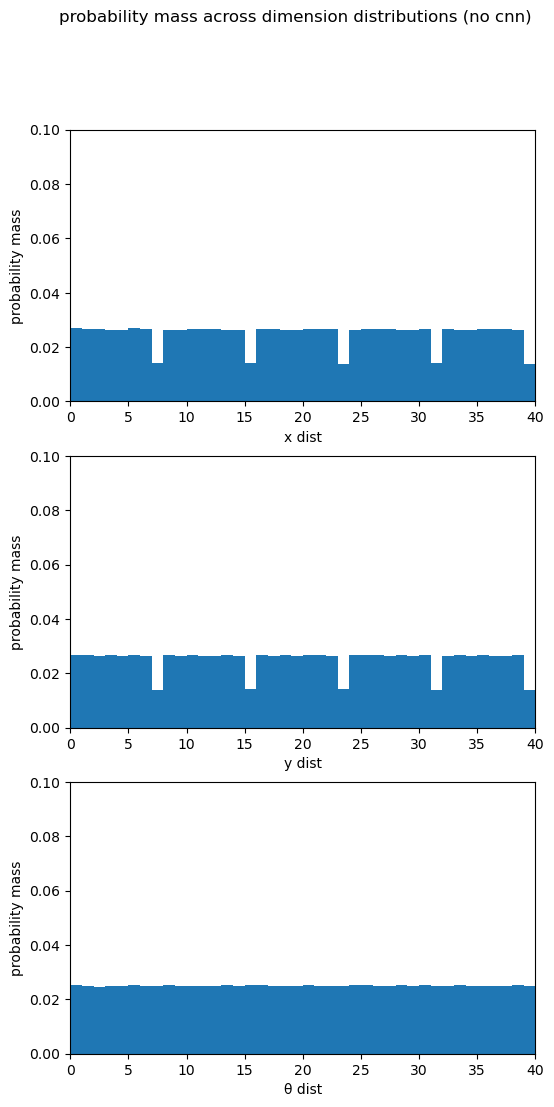

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

plot_probability_distribution_on_ax(no_cnn_x_dists[0], axs[0])
axs[0].set_xlabel('x dist')
axs[0].set_xlim(0, len(no_cnn_x_dists[0]))

plot_probability_distribution_on_ax(cnn_y_dists[0], axs[1])
axs[1].set_xlabel('y dist')
axs[1].set_xlim(0, len(no_cnn_y_dists[0]))

plot_probability_distribution_on_ax(cnn_theta_dists[0], axs[2])
axs[2].set_xlabel('θ dist')
axs[2].set_xlim(0, len(no_cnn_theta_dists[0]))

for i in range(3):
  axs[i].set_ylabel('probability mass')
  axs[i].set_ylim(0, 0.1)

fig.suptitle("probability mass across dimension distributions (no cnn)")

In [55]:
fig.savefig("results_across_dims_no_cnn.png")